In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/feature_engineered_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFIFA version distribution:")
print(df['fifa_version'].value_counts().sort_index())
print(f"\nTarget distribution:")
print(df['big_potential'].value_counts())

Dataset shape: (41458, 29)

FIFA version distribution:
fifa_version
17.0    8889
18.0    8814
19.0    8777
20.0    8091
21.0    6887
Name: count, dtype: int64

Target distribution:
big_potential
0    31162
1    10296
Name: count, dtype: int64


In [12]:
# Define temporal splits
train_versions = [17.0, 18.0, 19.0,20.0]

test_version = 21.0


df_train = df[df['fifa_version'].isin(train_versions)]

df_test = df[df['fifa_version'] == test_version]

print(f"Train (FIFA 17-20): {len(df_train)} samples")

print(f"Test (FIFA 21): {len(df_test)} samples")
print(df_train["big_potential"].value_counts())

Train (FIFA 17-20): 34571 samples
Test (FIFA 21): 6887 samples
big_potential
0    25968
1     8603
Name: count, dtype: int64


In [13]:

feature_columns = [col for col in df.columns if col not in ['fifa_version', 'big_potential']]
target = 'big_potential'

print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns}")

# Prepare datasets
X_train = df_train[feature_columns]
y_train = df_train[target]
print(X_train.shape)
X_test = df_test[feature_columns]
y_test = df_test[target]
print(X_test.shape)

Number of features: 27
Features: ['age', 'physic', 'mentality_aggression', 'mentality_interceptions', 'power_stamina', 'power_strength', 'defending_marking_awareness', 'power_jumping', 'defending_standing_tackle', 'defending_sliding_tackle', 'attacking_heading_accuracy', 'mentality_composure', 'movement_reactions', 'skill_long_passing', 'skill_dribbling', 'skill_fk_accuracy', 'skill_ball_control', 'attacking_crossing', 'power_shot_power', 'attacking_finishing', 'skill_curve', 'movement_balance', 'attacking_volleys', 'power_long_shots', 'mentality_vision', 'mentality_penalties', 'movement_agility']
(34571, 27)
(6887, 27)


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




In [15]:
from xgboost import XGBClassifier as xgb
model_xgb=xgb(
   n_estimators=200,      # Balanced number of trees
    max_depth=8,            # Shallower to prevent overfitting
    learning_rate=0.03,     # Conservative learning rate
    reg_alpha=0.001,          # Higher regularization
    reg_lambda=0.001,   
    scale_pos_weight=3,    
    eval_metric="logloss",
    random_state=42
)
model_xgb.fit(X_train_scaled, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    precision_score, recall_score
)

# Predictions on test set
y_test_pred = model_xgb.predict(X_test_scaled)
y_test_proba = model_xgb.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("="*60)
print(" MODEL - test Set (FIFA 21) Metrics")
print("="*60)
print(f"\nAccuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_test, y_test_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_test, y_test_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")

In [16]:
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    precision_score, recall_score
)

# Predictions on test set
y_test_pred = model_xgb.predict(X_test_scaled)
y_test_proba = model_xgb.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("="*60)
print(" MODEL - test Set (FIFA 21) Metrics")
print("="*60)
print(f"\nAccuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_test, y_test_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_test, y_test_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")

 MODEL - test Set (FIFA 21) Metrics

Accuracy:  0.7266
Precision: 0.4615
Recall:    0.6734
F1 Score:  0.5477
ROC-AUC:   0.7780

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.87      0.74      0.80      5194
   Big Potential       0.46      0.67      0.55      1693

        accuracy                           0.73      6887
       macro avg       0.67      0.71      0.68      6887
    weighted avg       0.77      0.73      0.74      6887

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------
                  Predicted
                  No BP    BP
Actual No BP      3864   1330
Actual BP          553   1140


In [19]:
y_train_pred = model_xgb.predict(X_train_scaled)
y_train_proba = model_xgb.predict_proba(X_train_scaled)[:, 1]

print("="*60)
print("BASELINE MODEL - training Set  Metrics")
print(f"\nAccuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_train, y_train_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)

print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_train, y_train_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_train, y_train_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")

BASELINE MODEL - training Set  Metrics

Accuracy:  0.8247
Precision: 0.6007
Recall:    0.8813
F1 Score:  0.7144
ROC-AUC:   0.9237

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.95      0.81      0.87     25968
   Big Potential       0.60      0.88      0.71      8603

        accuracy                           0.82     34571
       macro avg       0.78      0.84      0.79     34571
    weighted avg       0.87      0.82      0.83     34571

------------------------------------------------------------
ROC-AUC:   0.9237

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.95      0.81      0.87     25968
   Big Potential       0.60    

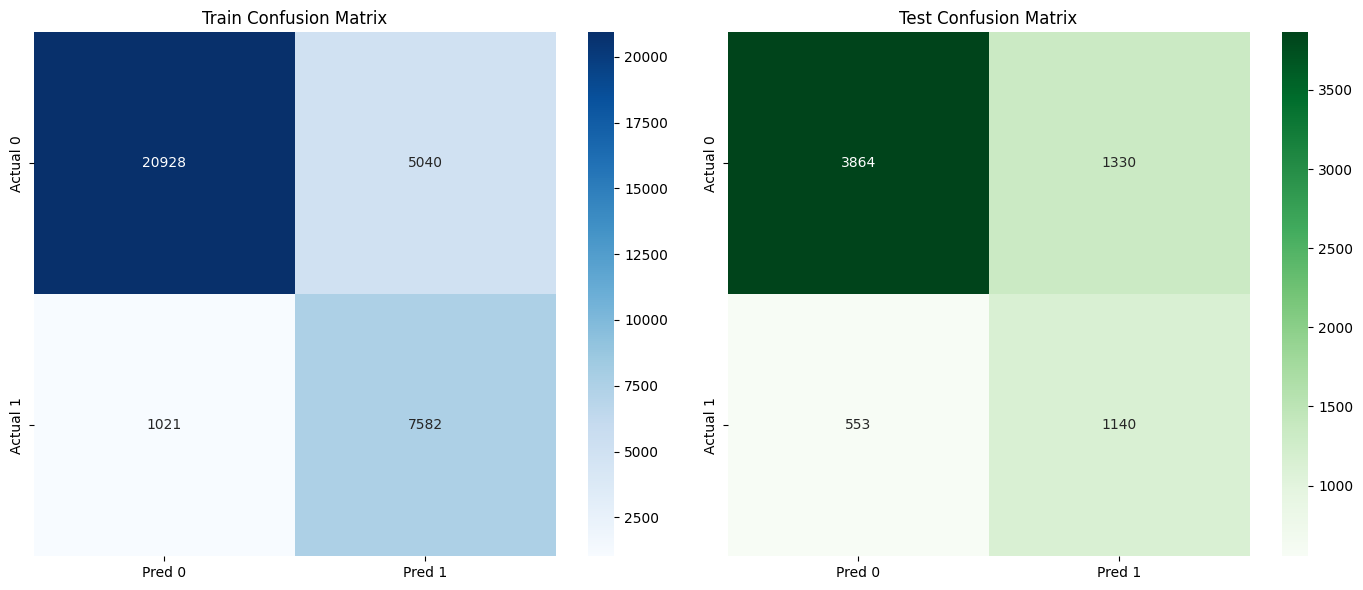

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Your matrices
test_cm = np.array([[3864, 1330],
                    [553, 1140]])

train_cm = np.array([[20928, 5040],
                     [1021, 7582]])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- TRAIN CONFUSION MATRIX ---
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Actual 0", "Actual 1"],
            ax=axes[0])
axes[0].set_title("Train Confusion Matrix")

# --- TEST CONFUSION MATRIX ---
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Actual 0", "Actual 1"],
            ax=axes[1])
axes[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()

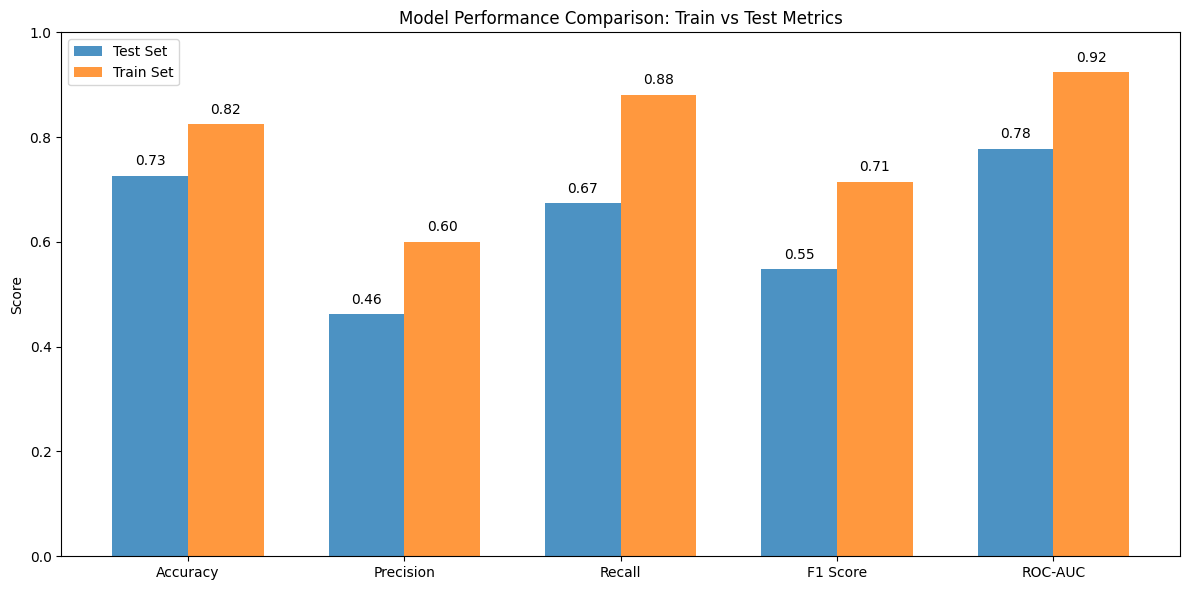

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]

test_scores = [0.7266, 0.4615, 0.6734, 0.5477, 0.7780]
train_scores = [0.8247, 0.6007, 0.8813, 0.7144, 0.9237]

# X positions
x = np.arange(len(metrics))
width = 0.35  # bar width

plt.figure(figsize=(12, 6))

# Bars
plt.bar(x - width/2, test_scores, width, label="Test Set", alpha=0.8)
plt.bar(x + width/2, train_scores, width, label="Train Set", alpha=0.8)

# Labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Model Performance Comparison: Train vs Test Metrics")
plt.legend()

# Show values on bars
for i, v in enumerate(test_scores):
    plt.text(i - width/2, v + 0.02, f"{v:.2f}", ha="center")

for i, v in enumerate(train_scores):
    plt.text(i + width/2, v + 0.02, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.show()